<a href="https://colab.research.google.com/github/nadavo11/K_means_cluster/blob/master/EM_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GMM implementation


The Gaussian Mixture Model is a statistical model that assumes that the observations follow a normal distribution, ie $f(x|z)$ is a Gaussian distribution with expectation $µ_Z$ and covariance matrix $Σ_Z$. The random variable $Z$
is a hidden variable.


#### our data generator: 

after implementing the MLE algorithm, we will use it to cluster data that we will generate using the gaussian data generator (from exercise 0).

Let us define the datapiont generator:

In [ ]:
import random

import numpy as np
import matplotlib.pyplot as plt


def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster

In [51]:
def generate_clusters(k, d = 2, distance = 2):

    """
    generate k clusters of d-dimensional data

    :param k:           number of clusters
    :param d:           dimension of the data
    :param distance:    expected distance of the mean from the origin
    :return:            clusters - a list of clusters, where each cluster is a numpy array of datapoints
                        data - a numpy array of all the datapoints
                        phi - a numpy array of the priors of each cluster
                        sigma - a numpy array of the covariance matrices of each cluster
    """
    phi = np.random.rand(k)
    phi = phi/np.sum(phi)
    print(phi)

    # random distributions
    distributions = [get_random_gaussian_dist(d,distance) for i in range(k)]
    print(distributions[0])
    # generate clusters
    clusters = [generate_gaussian_cluster(distribution,int(phi[i]*N),d) for i, distribution in enumerate(distributions)]

    sigma = [distribution[1] for distribution in distributions]
    data = np.concatenate(clusters,axis=0)

    return clusters, data, phi, sigma


def plot_clusters(clusters, d = 2,title = None,ax = None):

    """
    Function to plot the clusters
    input: clusters - a list of clusters, where each cluster is a numpy array of datapoints
           d - the dimension of the data
    output: a plot of the clusters, where each cluster is a different color, and the datapoints are transparent to show overlapping clusters

    """
    if not ax:
        plt.figure()
    if d == 2:
        for c in clusters:
            plt.scatter(c[:,0], c[:, 1], alpha=0.5)
    else:
        ax = plt.axes(projection='3d')

        for c in clusters:
            ax.scatter3D(c[:,0], c[:, 1], c[:, 2], alpha=0.5)
    if title:
        plt.title(title)



In [61]:
def generate_clusters(k, d = 2,N = 600, distance = 2):
    """
    generate k clusters of d-dimensional data

    :param k:           number of clusters
    :param d:           dimension of the data
    :param distance:    expected distance of the mean from the origin
    :return:            clusters - a list of clusters, where each cluster is a numpy array of datapoints
                        data - a numpy array of all the datapoints
                        phi - a numpy array of the priors of each cluster
                        sigma - a numpy array of the covariance matrices of each cluster
    """
    phi = np.random.rand(k)
    phi = phi/np.sum(phi)
    print(phi)

    # random distributions
    distributions = [get_random_gaussian_dist(d,distance) for i in range(k)]
    print(distributions[0])
    # generate clusters
    clusters = [generate_gaussian_cluster(distribution,int(phi[i]*N),d) for i, distribution in enumerate(distributions)]

    sigma = [distribution[1] for distribution in distributions]
    data = np.concatenate(clusters,axis=0)

    return clusters, data, phi, sigma


## MLE Overview

this time we will use the MLE algorithm to cluster the data.

pseudo code: The MLE algorithm goes as follows

here is MLE algorithm in pseudo code

1.until convergence, repeat:
    
   #### E-step:
   1. For each data point $x_i$:

        1. Compute the probability that $x_i$ belongs to each of the clusters, $p_{i,j}$

        2. Use these probabilities to compute the expected value of the cluster assignment, $w(i,j) = \frac{P(x_i \in Z_j)*\phi_j}{ \sum_{j = 0}^{k} P(x_i \in Z_j) \cdot \phi_j}$

#### M-step:
   1. For each cluster $j$:

        1. compute the new mean, $\mu_j$

        2. compute the new variance, $\sigma^2_j$

        4. compute the new prior, $ \phi_j$
        
        
this is what the implementation looks like:

In [444]:
def draw_contour(phi,mu,sigma):
    N    = 200
    X    = np.linspace(-1, 3, N)
    Y    = np.linspace(0, 4, N)
    X, Y = np.meshgrid(X, Y)
    pos  = np.dstack((X, Y))
    rv   = P(mu, sigma*phi)
    Z    = rv.pdf(pos)
    plt.contour(X, Y, Z,levels = 6)

In [393]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as P


def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0
    
    for i in range(n):
        norm_i = 0
        for j in range(k):
            w[j, i] = P(mu[j], sigma[j],allow_singular=True).pdf(data[i]) * phi[j]
            norm_i += w[j, i]
        w[:, i] /= norm_i
        
        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w)
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j])
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def MLE(data, initial_model, case = 2, plot = True,tol = 0.00001 ,contoure = False):
    """
    MLE algorithm: Cluster the given data into k, d-dimensional gaussian distribution using the MLE algorithm
    :param data:            (n,d) array of data points
    :param initial_model:   (phi, mu, sigma) tuple of initial gaussian model parameters
    :param case:            1 for known covariance, and cluster probability phi, 2 for fixed
    :param plot:
    :param tol:
    :param contoure:
    :return:                (phi, mu, sigma) tuple of gaussian model parameters
    """
    d = data.shape[1]

    # 1. Initialize model parameters

    phi, mu, sigma = initial_model

    k = len(phi)
    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]



    while not converged and i<150:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        if case == 1:
            PHI, SIGMA = phi, sigma
            _, mu, _ = M_step(data, w, phi, mu, sigma)
            phi, sigma = PHI, SIGMA
        if case == 2:
            phi, mu, sigma = M_step(data, w, phi, mu, sigma)
        

        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < tol)

        # Plot:
        if plot:
            if i%20 == 0 or i < 4 or converged:
                if d == 2:
                    plt.figure()
                    c= np.sum(w * np.arange(k)[: , np.newaxis], axis=0)

                    plt.scatter(data[:,0], data[:, 1], c=c, alpha=0.5,cmap='RdYlBu')
                    if contoure:
                        for t in range(k):
                            draw_contour(phi[t],mu[t],k*sigma[t])
                    plt.title("iteration #" + str(i))
                    plt.show()
                if d == 3:
                    fig = plt.figure()
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(data[:,0], data[:, 1], data[:, 2], c=1+w[0]-w[1], alpha=0.5,cmap='RdYlBu')
                    plt.title("iteration #" + str(i))
                    plt.show()
        else:
            if i%20 == 0 or i < 4 or converged:
                fig = plt.figure()

                c= np.sum(w * np.arange(k)[: , np.newaxis], axis=0)
                if d ==3:
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(data[:,0], data[:, 1], data[:, 2], c=c, alpha=0.5)
                else:
                    plt.scatter(data[:,0], data[:, 1], c=c, alpha=0.5,cmap='RdYlBu')
                plt.title("iteration #" + str(i))

    # 5. return model
    return phi, mu, sigma,  iteration_log_likelihood



In [163]:
# 2d array of data points


### Initial Model:

the MLE algorithm we needs an initial model to start with. as described above algorithm demands an initial value  $\theta^0$ ie. initial values
for:  $\mu_j , \sigma^2_j , \phi_j$ for each gaussian $j$ in the model, in order to calculate the first E-step, ie. the probability of each data point to belong to each gaussian. $p(z_i = j | x_i, \theta^0)$ which is the first estimation of the latent variables $w_{ij}$.

one idea would be to use K-means algorithm to initialize the means of the model. we will experiment with tat later, but first we will try initiating with an arbitrary choise, as such:

In [330]:
def initial_model(k,d,phi =None, sigmas =None, data=None):
    """

    :param c: # of Gaussians in model
    :param d: # of dimentions of datapoints

    :return: an arbitrary initial condition  model for MLE. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """

    mu = np.array([np.random.multivariate_normal([0]*d, np.eye(d,d)) for i in range(k)])
    # mu will be k different random points in the data
    if data is not None:
        mu = data[np.random.choice(len(data), k, replace=False)]

    if phi is None or sigmas is None:
        phi = np.random.rand(k)
        phi /= sum(phi)


        sigmas = np.zeros((k,d,d))

        for i in range(k):
            sigma = np.random.rand(d, d)
            sigma = np.dot(sigma, sigma.T)
            sigmas[i] = sigma
        print("initiating a random model...")

    else:
        print("initiating a model with given phi,sigma...")
    # print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigmas)
    return phi, mu, sigmas

## convergence conditon:

we will also like to decide when to stop the algorithm. for one thing, we will limit the maximal # of iterations to a fixed number. for another, the algorithm increases the log likelihood, i.e., $ log P(x^n |/theta^t$
so we will calculate the log likelihood at each step, as follows:

Log Likelihood:

$ log P(x^n |\theta ^t )= log(\sum_j P(x^n , z^n ;\theta ^t))$


$= log( \prod_i\sum_j  N(x_i, \mu_j , \sigma^2_j ; \theta ^t)* \phi_j)$


$= \sum_i log( \sum_j  w(j,i))$


and compare to previous value, to check for convergence.

In [6]:
def plot_log_likelihood(lol):
    plt.plot(range(len(lol[2:])),lol[2:])
    plt.title("log likelyhood vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|log liklyhood|")
    plt.show()

# first experiment: full & diagonal covariance matrix

## Case I:
#### $\phi$ and $\sigma$ are known,
here there is no need to update the variables responsible to the "shape" of the distribution, i.e. the covariance matrix $\sigma$ and the amplitude $\phi$  we are looking for the centroids, $\mu$


in case 1,we are given the variance matrecies, ie.
$$\Sigma_1 = \begin{bmatrix}
0.6 & 0 \\
0 & 0.6
\end{bmatrix}
,
\Sigma_2 = \begin{bmatrix}
0.8 & -0.3 \\
-0.3 & 0.6
\end{bmatrix}$$
we are also given the probability for the first label:

$$\phi_1 = P_Z(1) = 0.7$$

and we only use the MLE algorithm to find the means for each of the clusters.
$$\mu_1 = \begin{bmatrix}
a \\
b
\end{bmatrix}
,
\mu_2 = \begin{bmatrix}
c \\
d
\end{bmatrix}$$






### generate the data

In [219]:
k=2         # number of clusters
d=2         # number of dimentions
N = 500    # number of datapoints

phi = [0.7, 0.3]
sigma = [np.array([[0.6,0],[0,0.6]]),np.array([[0.8,-0.3],[-0.3,0.6]])]
mu = [np.array([1,1]),np.array([-1,-1])]
distribution_1 = (mu[0],sigma[0])
distribution_2 = (mu[1],sigma[1])

cluster_1 = generate_gaussian_cluster(distribution_1,int(phi[0]*N),d)
cluster_2 = generate_gaussian_cluster(distribution_2,int(phi[1]*N),d)

data = np.concatenate((cluster_1,cluster_2),axis=0)

### plot the data

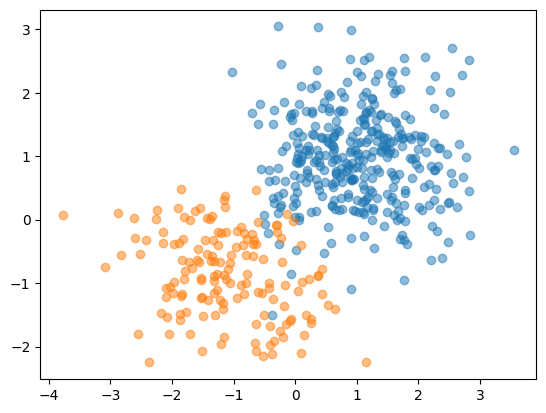

In [220]:
data = np.array(data)

#colors = np.random.rand(N)
plt.scatter(cluster_1[:,0], cluster_1[:, 1],  alpha=0.5)
plt.scatter(cluster_2[:,0], cluster_2[:, 1],  alpha=0.5)
plt.show()

### plot the data without assignment to clusters

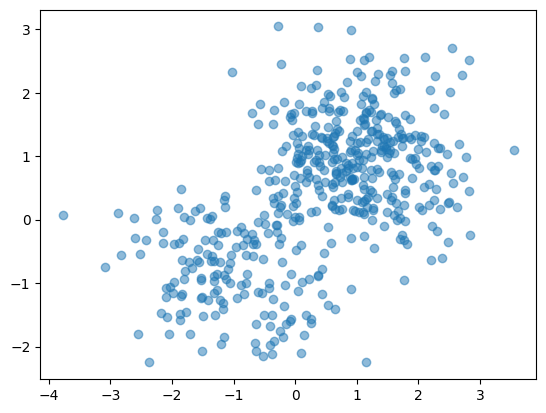

In [225]:
plt.scatter(data[:,0], data[:, 1],  alpha=0.5)
plt.show()

### run the algorithm


In [237]:
init = initial_model(k,d,phi,sigma)

initiating a model with given phi,sigma...


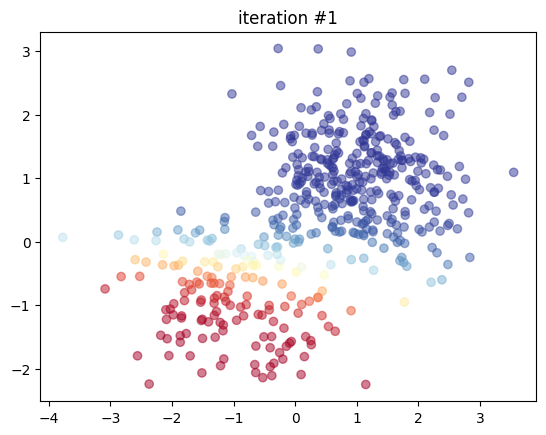

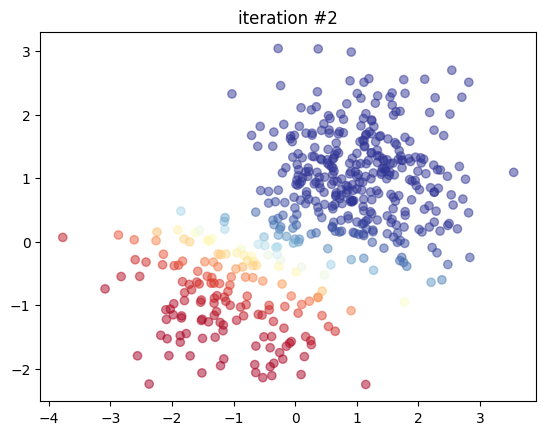

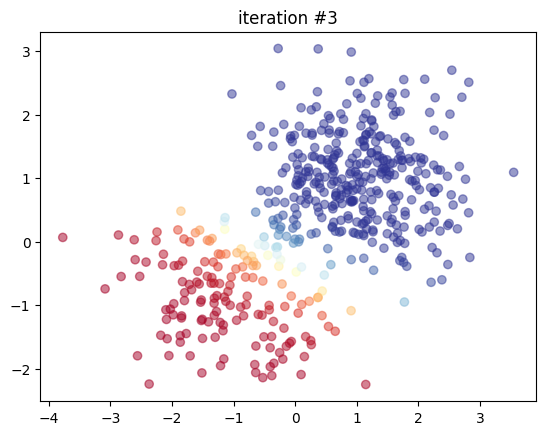

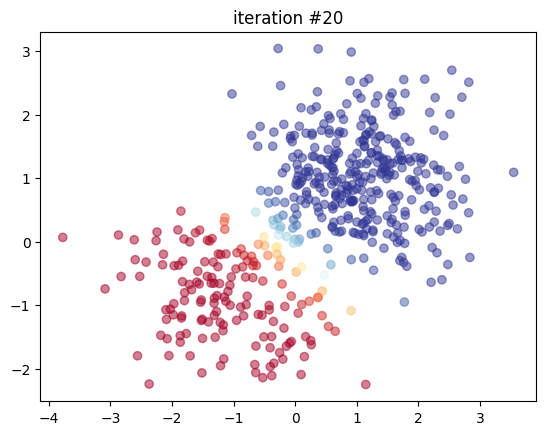

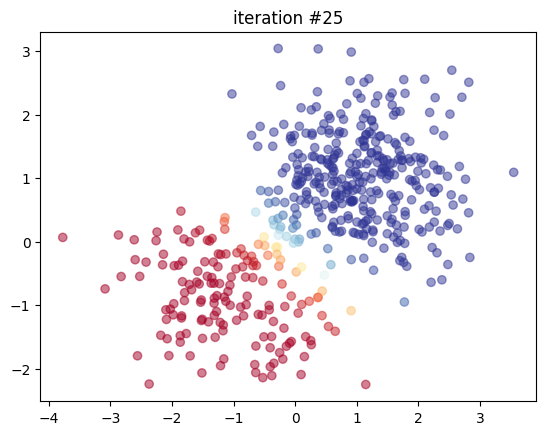

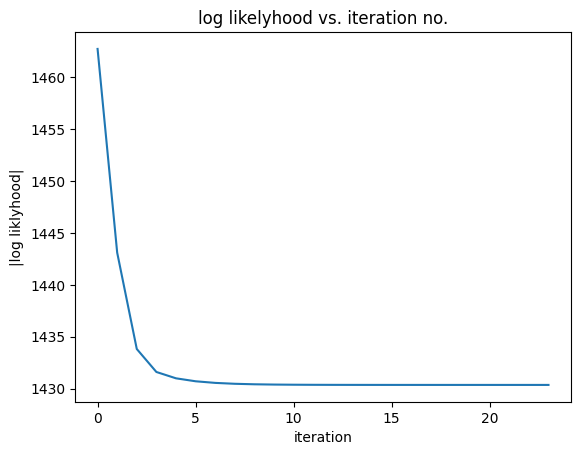

In [238]:

phi, mu, sigma, lol = MLE(data,init,case=1)

plot_log_likelihood(lol)

## results
even though we are not given the centroids, and the initial guessed centroids are in incorrect positions, the algorithm converged to the correct centroids in a pretty steep convergence curve. in 20 iterations, the algorithm returned, and we can see that the log likelihood is near its maximum after ~5 iterations, a remarkable rate indeed. this is because given the shape of the gaussians the algorithm can easily find where the shapes fit the data best.

## Case II:
#### $\phi$ $\sigma$ and $\mu$ are unknown

in case 2, we are not given the variance matrecies, nor the probability for the first label, so we are looking for the centroids, $\mu$ and the variance matrecies $\sigma$ and the amplitude $\phi$
could it be that the algorithm will converge to the same values as in case 1?

sience we are not given the variance matrecies, we will have to calculate them at each iteration, using the centroids we found so far, and the labels we assigned to each datapoint.
we will initialize the model to a random gaussian distribution, and run the algorithm.

#### run the algorithm on the same data

initiating a random model...


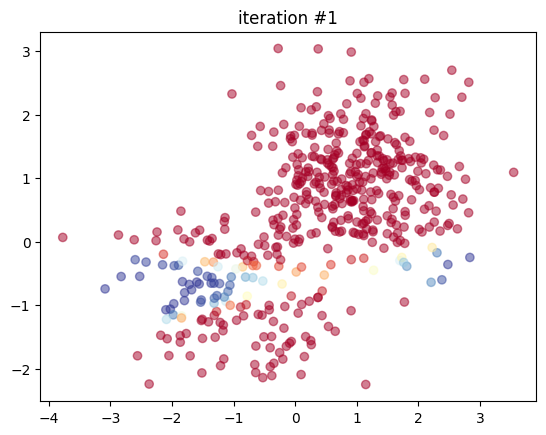

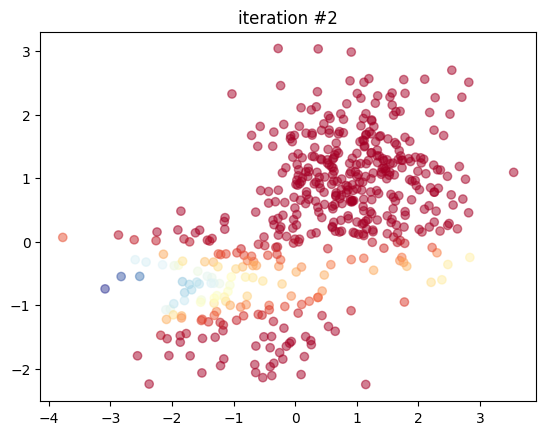

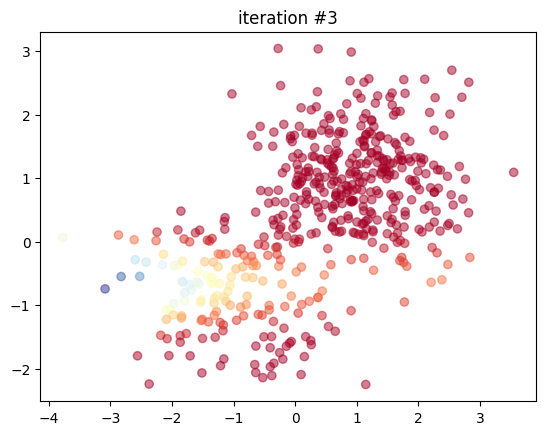

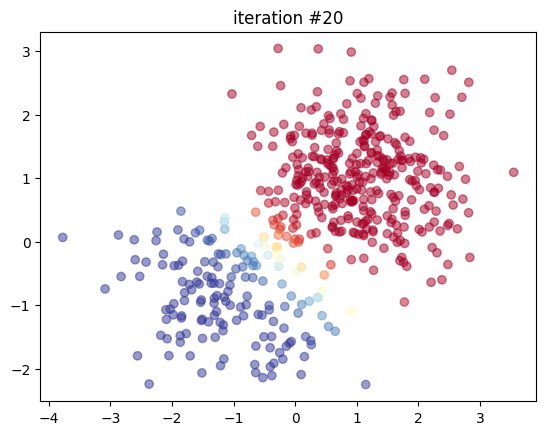

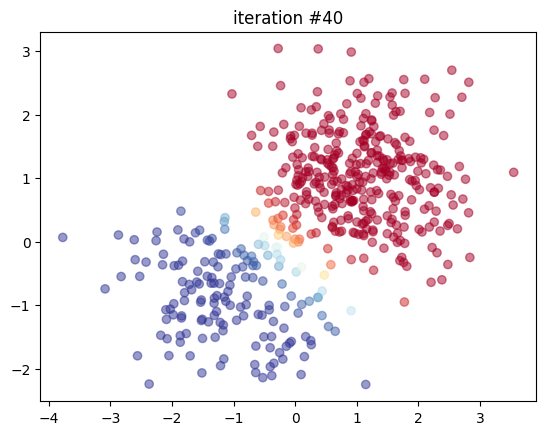

In [229]:
phi, mu, sigma, lol = MLE(data,initial_model(k,d),case=2)


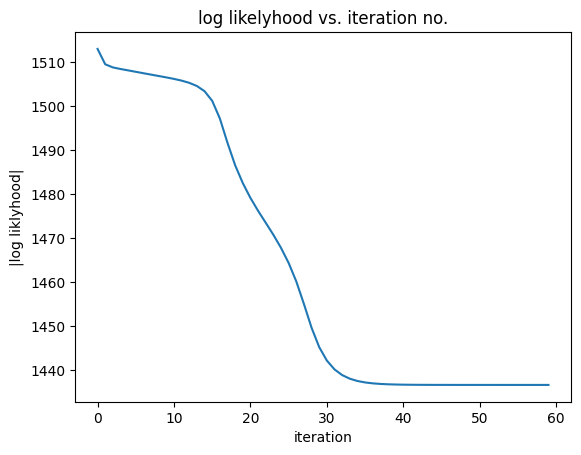

phi: [0.29587397 0.70412603]
mu: [[-1.01095116 -0.94068821]
 [ 0.95711664  0.92984149]]
sigma: [[[ 0.81837029 -0.32739841]
  [-0.32739841  0.51533522]]

 [[ 0.59978428  0.07430805]
  [ 0.07430805  0.66266346]]]


In [29]:
plot_log_likelihood(lol)

print(f'phi: {phi}\nmu: {mu}\nsigma: {sigma}')

### results
as we can clearly see, the initial guess was way off, but the algorithm converged to the actual values of the centroids, and the log likelyhood converged, although it took much more iterations to run (~40), this comes in contrast to a very sharp convergence graph in case 1. the algorithm is able to figure out the shapes of the gaussians, but it takes more time, trial, and error to do so. we can see the final model returned by the algorithm, by plotting the contours of the gaussians, and the data, the outcome is exactly what we would expect.

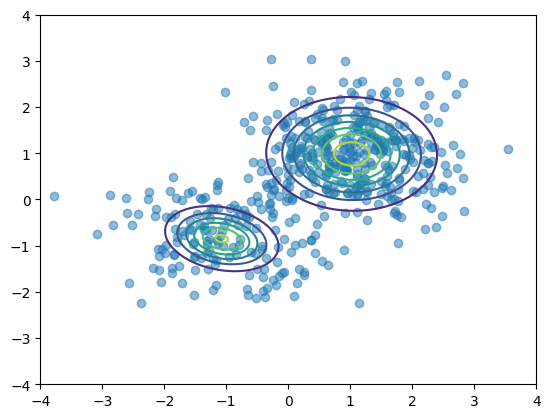

In [236]:
plot_clusters([data])

for a in range(k):
    draw_contour(phi[a],mu[a],sigma[a])

the model's parameters settle on the actual gaussians that are behind the data generation, and the log likelyhood converges, indicating that thealgorithm is likely to have stayed around said values, was it given even more iterations to run.

# second experiment: 3D data, full covariance matrix

### generate the data

In [311]:
k=2         # number of clusters
d=3         # number of dimentions
N = 500    # number of datapoints

phi2 = [0,1] + [1,-1]*np.random.rand(1)
print(phi2)
# generate the clusters
clusters2, data2, phi2, sigma2 = generate_clusters(k,d,N,2)


[0.30718388 0.69281612]
[0.61069092 0.38930908]
(array([1.46238122, 1.0276176 , 1.74745163]), array([[ 0.35943206,  0.30558658, -0.01421472],
       [ 0.30558658,  0.54400288, -0.16430025],
       [-0.01421472, -0.16430025,  0.15030465]]))


### plot the data on 3d plane

in this plot we can see the data on a 3d plane, plus, which datapoints belong to each cluster.

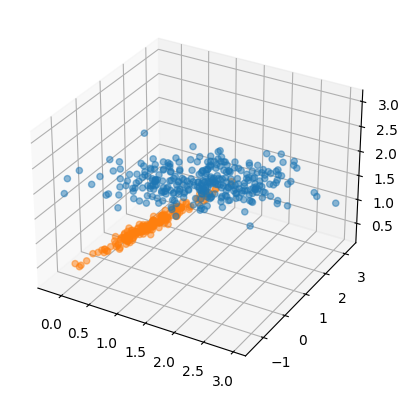

In [312]:

# scatter plot the points in the current cluster with the current color 🌈
plot_clusters(clusters2, d=3)

### plot the data without assignment to clusters

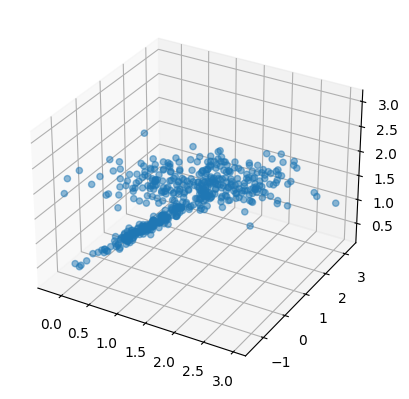

In [313]:
plot_clusters([data2], d=3)

## case I:
### run the algorithm
we will run the algorithm, and provide it with the underline $\phi$ and $\sigma$ matrecies, and see if it converges to the actual $\mu$ values.

initiating a model with given phi,sigma...
[[ 0.74011371 -0.18500477  0.9374336 ]
 [ 0.22858045 -0.27208438  1.62865766]]


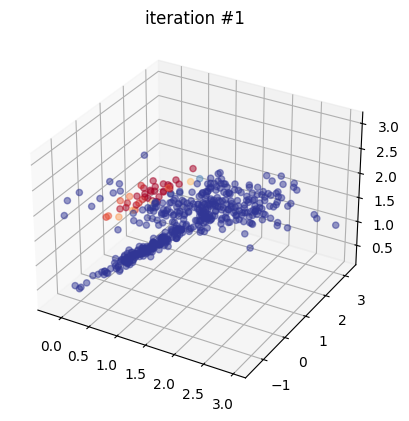

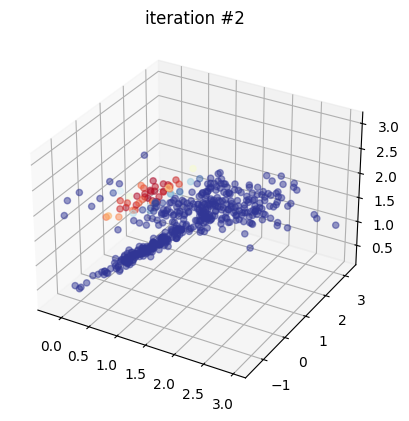

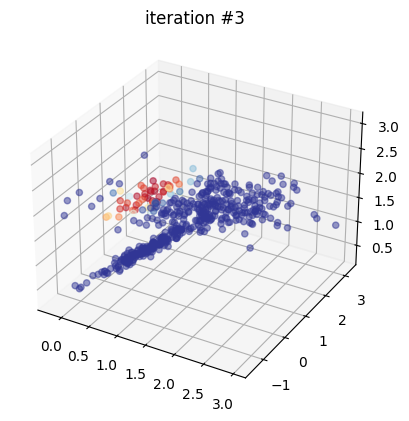

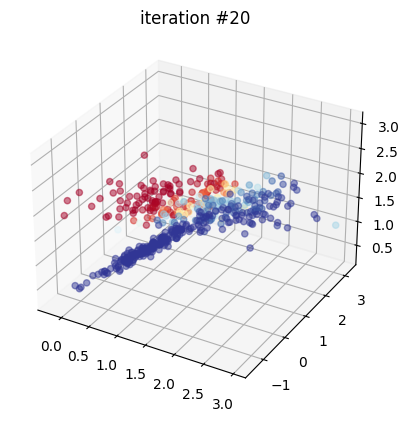

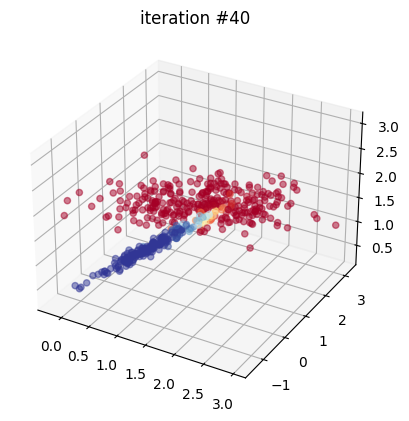

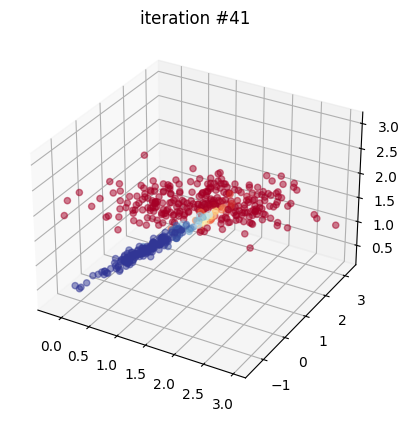

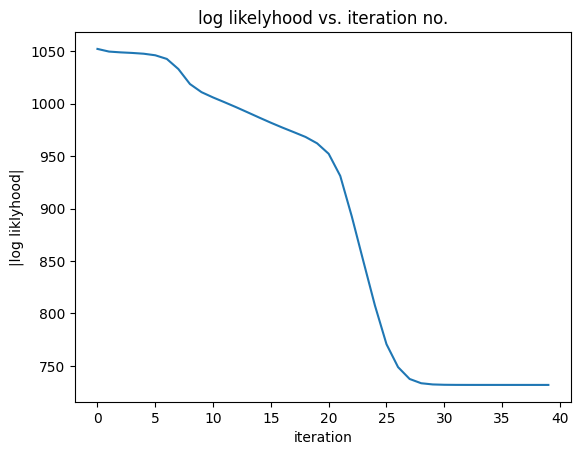

In [357]:

init = initial_model(k,d,phi2,sigma2_2,data=data2)

print(init[1])

phi2_1, mu2_1, sigma2_1, lol = MLE(data2,init,case=1)
plot_log_likelihood(lol)

### results

it took the algorithm ~20 iterations to converge.

## case II:

initiating a random model...


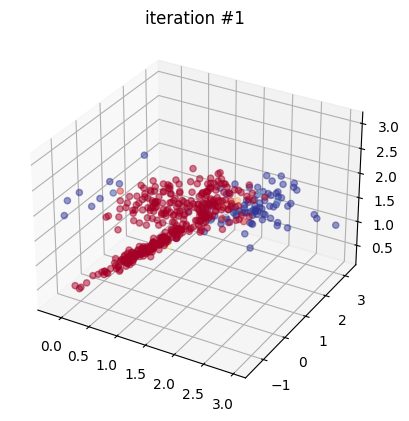

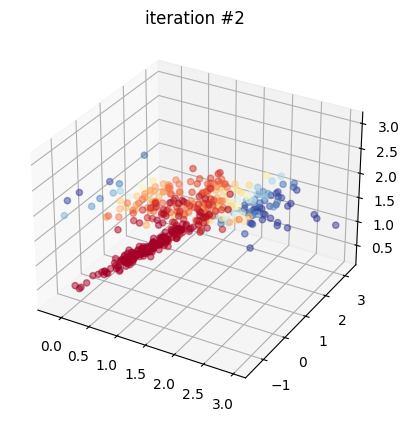

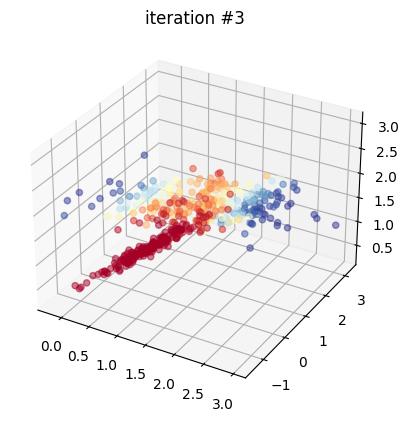

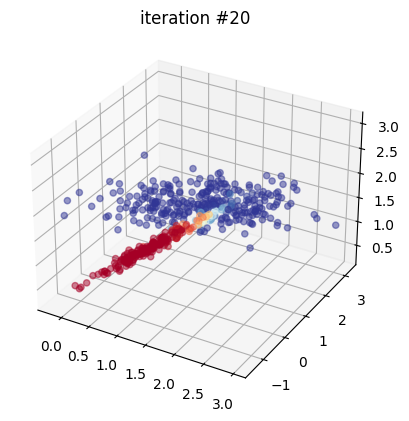

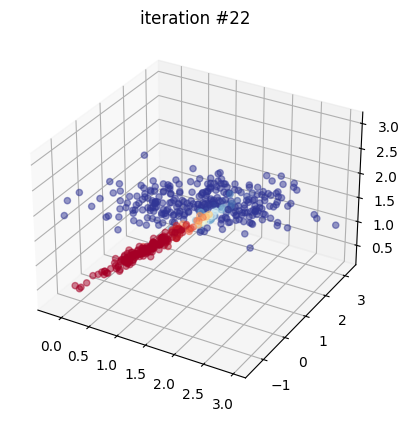

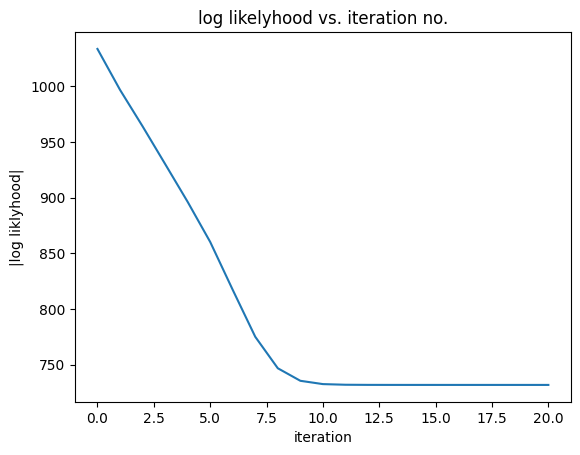

In [352]:
phi2_2, mu2_2, sigma2_2, lol = MLE(data2,initial_model(k,d),case=2)
plot_log_likelihood(lol)


### results
the results here are quite surprising, the algorithm converged to the actual centroids, and the log likelyhood converged, again, showing the effectiveness of the algorithm. but it took much more iterations to run (~40) in case I, ie. *with* sigma and phi given,then *without* the knowledge of the variance matrecies and the intensity of each cluster. why? because having the variance matrecies and the intensity of each cluster given makes the algorithm more volnurable to the initial guess, a 'bad' asignment of the centers can lead to a very slow convergence, as long as the estimated gaussian is far from the actual cluster, the estimated $\sigma^2$ metrix cannot be changed in the process, which slows down the process even more.

we can see on the convergence graph of CASE I that indeed the log likelyhood is not as steep as in case I, until the 'breakthrough' point around $iter =22$, where the algorithm finally assign most of the datapoints of the cluster with the bigger volume the correct cluster, then the log likelyhood converges rapidly.

in CASE II the convergence is faster, because the algorithm is not 'stuck' with the initial guess of the variance matrecies, and can change them as it sees fit, which makes the algorithm more robust to the initial guess of the centroids. it gets very close around ~10 iterations

# third experiment: 3D data, full covariance matrix, 4 clusters

### generate the data

In [ ]:
k=4         # number of clusters
d=3         # number of dimentions
N = 500    # number of datapoints
distance = 2
clusters3, data3, phi3, sigma3 = generate_clusters(k,d=d,N=N,distance=distance)


### plot the data on 3d plane

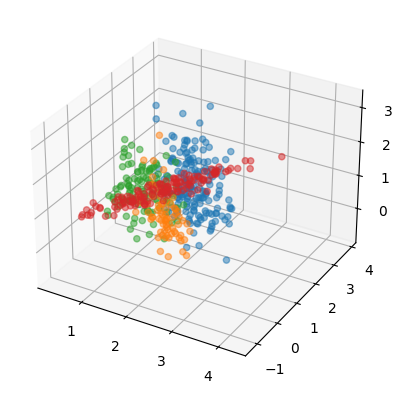

In [87]:
#ax = plt.axes(projection='3d')
# scatter plot the points in the current cluster with the current color 🌈
plot_clusters(clusters3, d=3)


### plot the data without knowladge of the latent

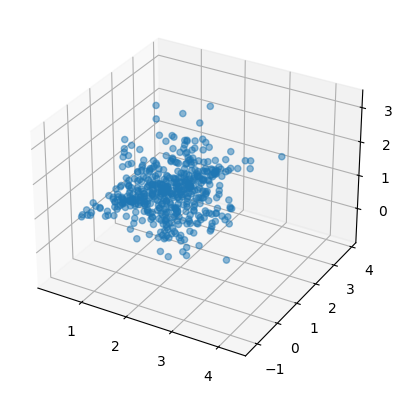

In [88]:
plot_clusters([data3],d=3)

## case I:
### run the algorithm



In [89]:
init = initial_model(k,d,phi3,sigma3,data = data3)

initiating a model with given phi,sigma...


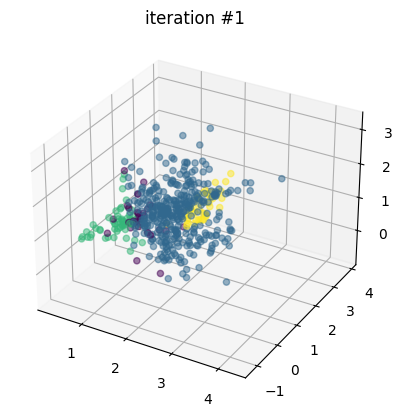

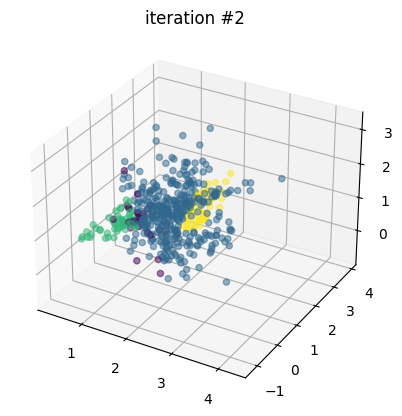

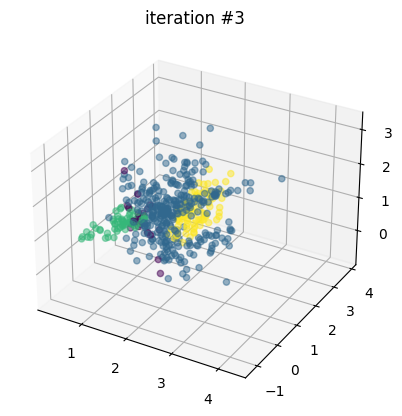

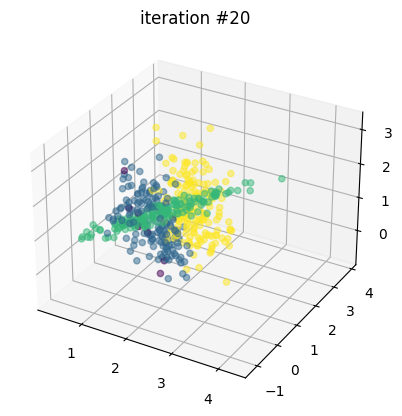

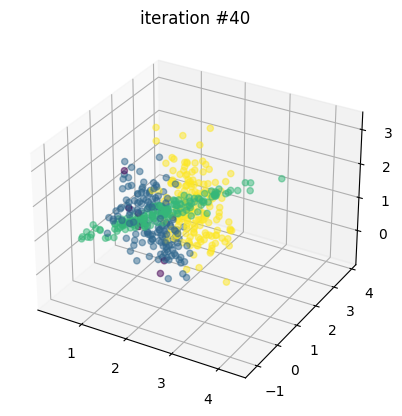

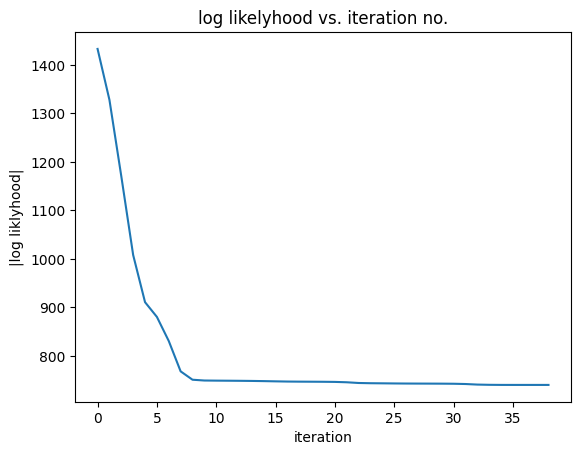

In [90]:
_,_,_, lol = MLE(data3,init,case=1,plot=False)
plt.figure()
plot_log_likelihood(lol)

### results



## case II:

initiating a random model...


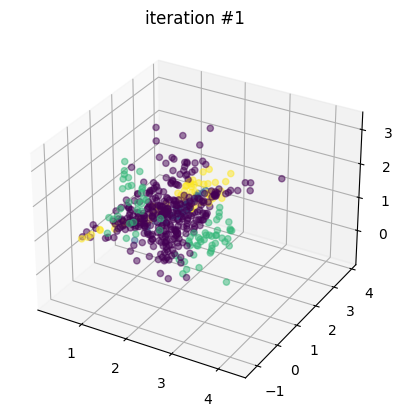

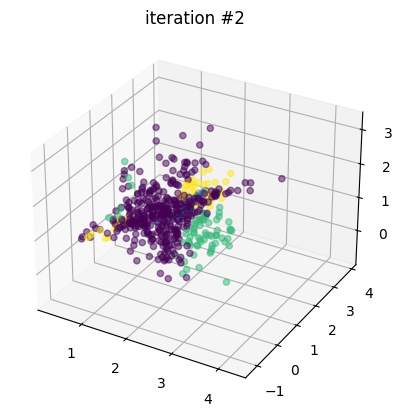

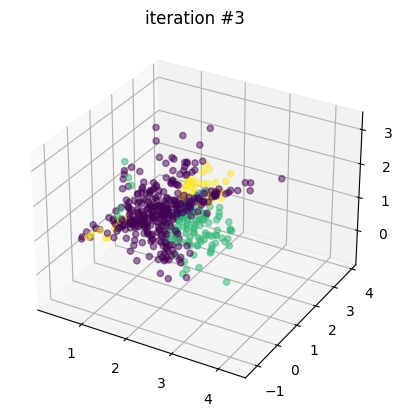

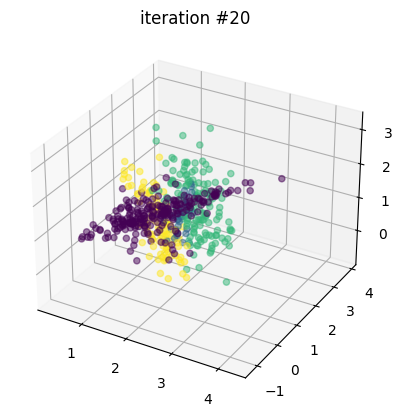

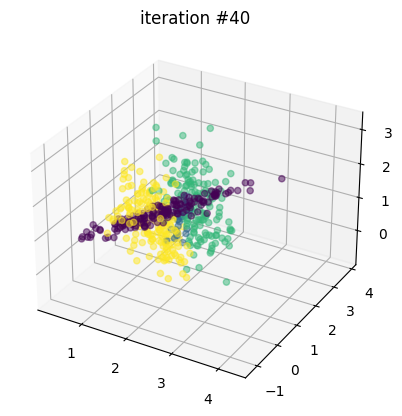

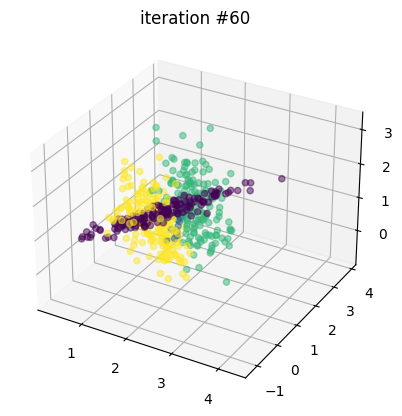

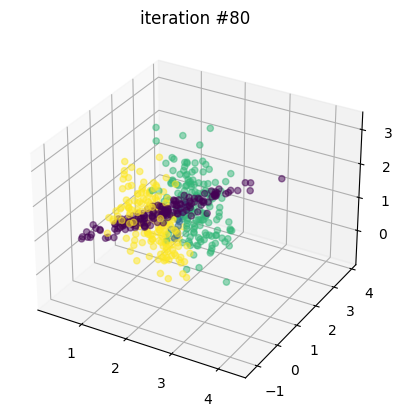

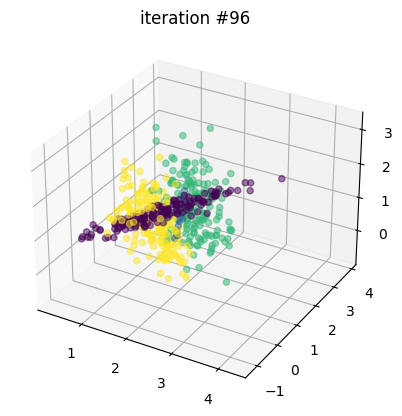

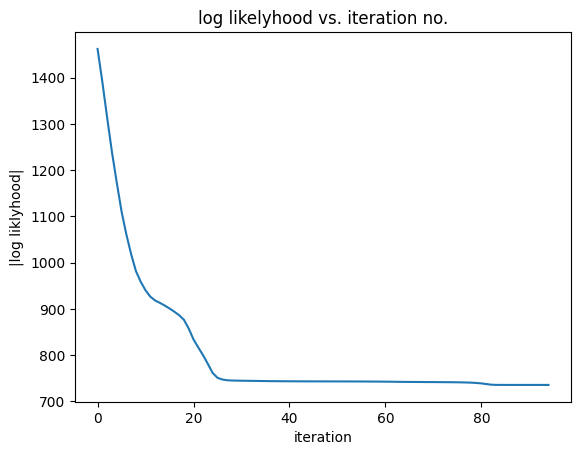

In [92]:
_,_,_,lol = MLE(data3,initial_model(k,d),case=2,plot=False)
plt.figure()
plot_log_likelihood(lol)

### results

# K - Means

# fourth experiment: 3D data, full covariance matrix, 4 clusters, K-Means as initial model

let us try the MLE on a dataset which is a bit challenging: we have gaussians of different shapes sizes and intensities, even when given $\sigma$ and $\phi$ matrecies, the algorithm is not likely to find an initial guess that will allow it to converge. then we will try to see if the K-Means algorithm can help us with that.

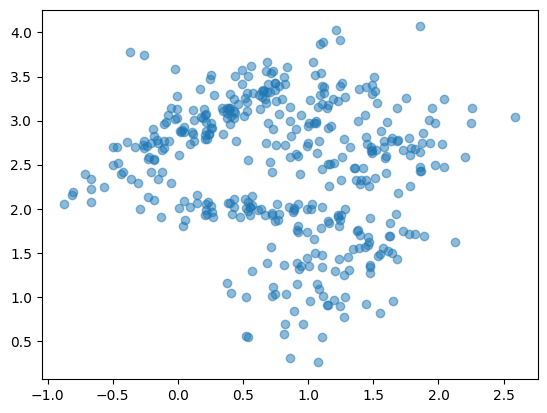

In [365]:
plot_clusters([data4])


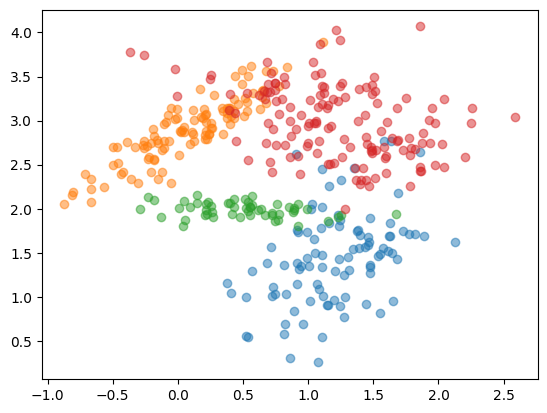

In [201]:
plot_clusters(clusters4)

initiating a random model...


C:\Users\nadav\AppData\Local\Temp\ipykernel_22512\838463208.py:56: RuntimeWarning: invalid value encountered in divide
  mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj


ValueError: array must not contain infs or NaNs

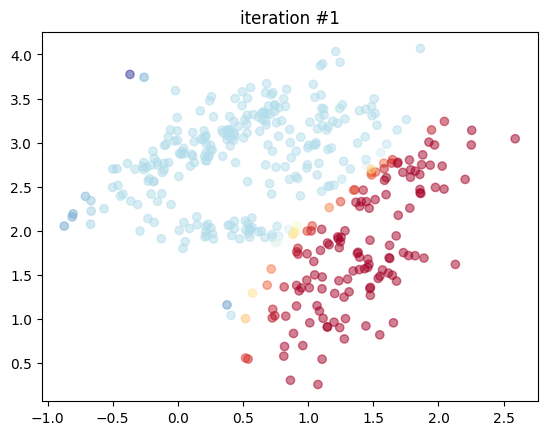

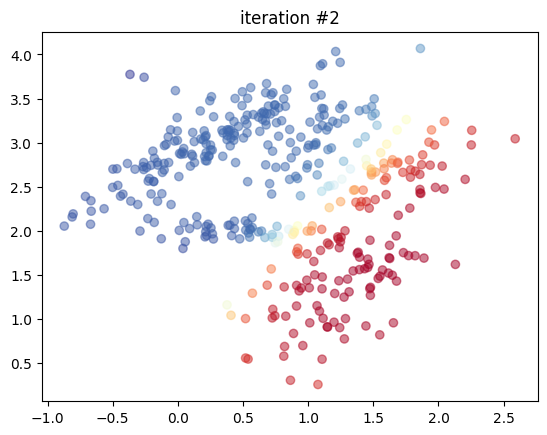

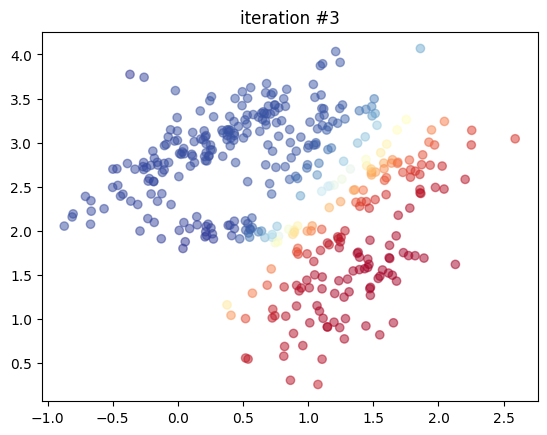

In [407]:
_,_,_,lol = MLE(data4,initial_model(4,2),case=2,plot=False)


the algorithm diverged, because of a 'bad' initial guess. in fact, most 'guesses' are likely to fail the algorithm in cases of a dataset such as right here. so, is there a smarter way to initialize the agorithm? we will try to use the K-Means algorithm to initialize the algorithm, and see if it helps.

## the k-means algorithm as a model initializer

GMM implementation with K-Means as an initial Model

we talked about the algorithm's need of an initial model, for the algorithm to start, and experimented with initiating at random (K - Gaussians picked at random, defined by:
- $\mu_j$ - the mean of each gaussian
- ${\sigma_j}^2 $ - the covariance (matrix) of each gaussian
- $\phi_j$ - the "amplitude" of each gaussian


this time we will try a more interesting method - use the K means algorithm's output to initiate $\mu_j$ . K- means is thoroughly explained in another paper in this repository, and is "hard" algorithm, in contrast to EM, which is considered "soft". in a few iterations,we get very close to the conclusion of the actual $\mu_j$
pseduo code:

##### Input

- Data points: $X = \{x_1, x_2, ..., x_n\}$ (a set of n data points)
- Number of clusters: $K$
##### Output:
- Cluster assignments: $c_i$ (each data point is assigned to a cluster)
- Centroids: $\{C_j\}_{j=0}^K$ (a set of $K$ cluster centroids)

##### Pseudo-Code:
1. Initialization: Start by randomly selecting $K$ initial cluster centroids, denoted as $C = {c_1, c_2, ..., c_K}$.
2. Iteration:
    -Assigning Data Points to Clusters:
    - For each data point $x_i$, find the nearest centroid and assign the point to that cluster. The assignment is based on minimizing the squared Euclidean distance: $$c_i = \arg\min_j ||x_i - c_j||^2$$
- Updating Cluster Centroids: For each cluster $C_j$, update the cluster centroid by calculating the new mean of all the data points assigned to that cluster. $$c_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i$$
3. repeat until the centroids converge:
    - if the centroids don't change, stop the algorithm
    - else, go back to step 2

In [117]:
def K_means_cluster(k, data, dim=2):
    # 1. randomly select k data points as
    #    centroids
    centroids = []
    for i in range(k):
        mean = random.choice(data)
        centroids.append(mean)
    i=0
    dif = 1
    tol= 0.0001
    # 3. repeat until the centroids converge:
    while (i <= 15) and dif > tol: #TODO: add condition
        previous_centroids = np.array(centroids)

        # 2. calculate the distance between
        #    each data point and each centroid
        d = []
        for dp in data:
            distance = [np.linalg.norm(dp - ci) for ci in centroids]
            d.append(distance)
        d = np.array(d)
        # d (data points x centroids),

        # 4. assign each data point to the cluster with the nearest centroid
        clusters = [[] for _ in range(k)]
        for j, dp in enumerate(d):
            closest_centroid = np.argmin(dp)
            clusters[closest_centroid].append(list(data[j]))

        clusters = [np.array(c) for c in clusters]


        # 5. recalculate the centroid of each cluster
        for j, c in enumerate(clusters):
            centroids[j] = np.mean(c,axis=0)
        #calculate the convergence condition
        dif = np.linalg.norm(np.array(centroids) - previous_centroids)

        #plot the clusters
        if i < 2 or dif <= tol or not i%5:
            plot_clusters(clusters)
            #plot the centroids marked by 'x'
            for c in centroids:
                plt.scatter(c[0],c[1],marker='x',color='black',s=100)

            plt.legend(loc='upper left')
            plt.title("K-means iteration #" + str(i))
            plt.show()

        i +=1
    # phi is the probability of each cluster in the data
    phi =np.array([len(clusters[t])/len(data) for t in range(k)])

    sigma = np.zeros((k,dim,dim))
    for j, c in enumerate(clusters):
        sigma[j] = np.mean([np.outer((d - centroids[j]).T, d - centroids[j]) for d in c],axis = 0)
    print ('finished')
    return phi, np.array(centroids), sigma


In [200]:
k=4         # number of clusters
d=2         # number of dimentions
N = 400    # number of datapoints
distance = 3 # distance between the means of the clusters

clusters4, data4, phi4, sigma4 = generate_clusters(k,d=d,N=N,distance=distance)

[0.23786351 0.27445184 0.13572012 0.35196453]
(array([1.19675723, 1.46323218]), array([[0.13854125, 0.08501191],
       [0.08501191, 0.25334835]]))


### initialize the model with K-means

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


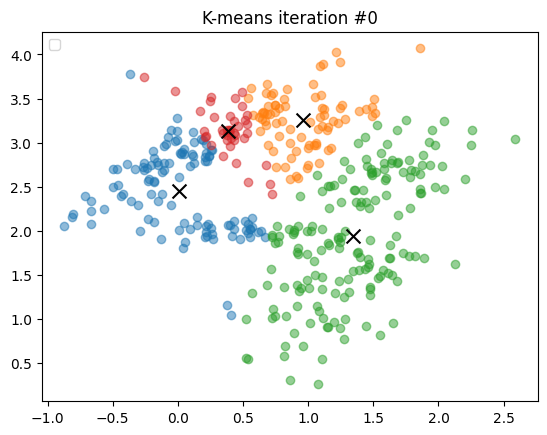

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


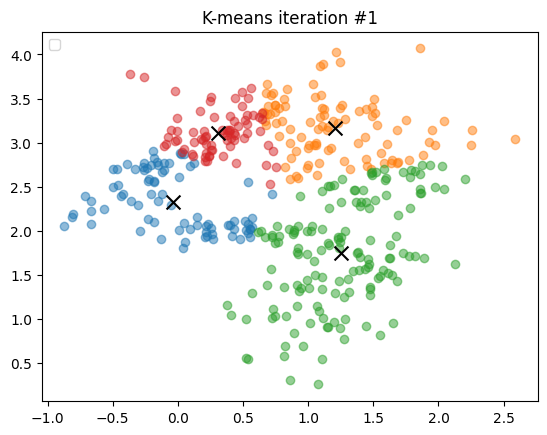

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


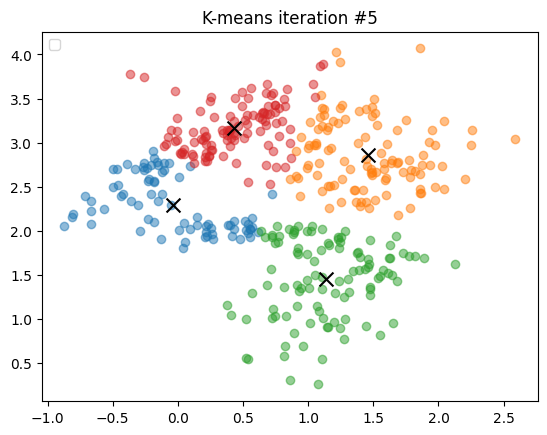

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


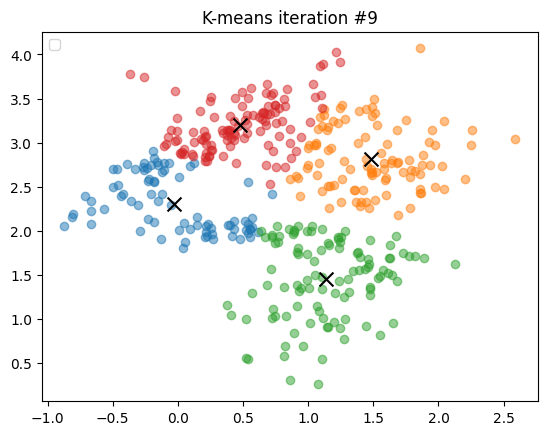

finished


In [410]:
phi4, centroids4, sigma4 = K_means_cluster(4,data4,dim=2)


now we can see k-mean algorithm's output, and the clusters it found. we can see that the clusters are not exactly the same as the ones we used to generate the data, but eans did an impressing job finding the centroids, plus it returned after mere 9 iterations. it is important to also remember, the computational intensity of each of those iteration is negligible compared to the MLE's iterations.

### run MLE


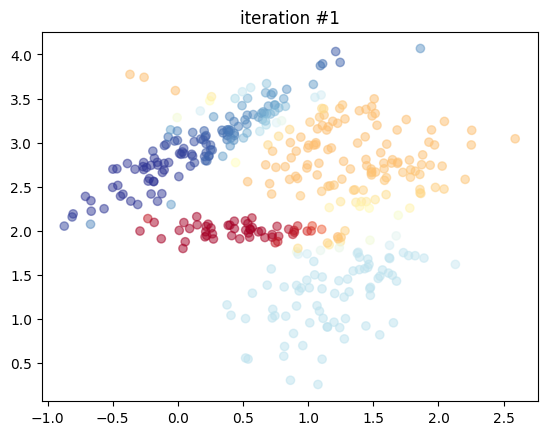

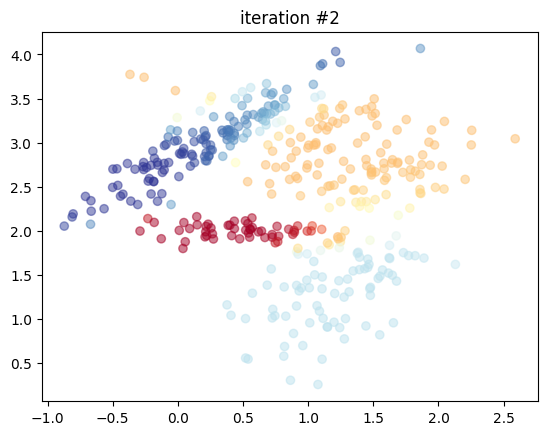

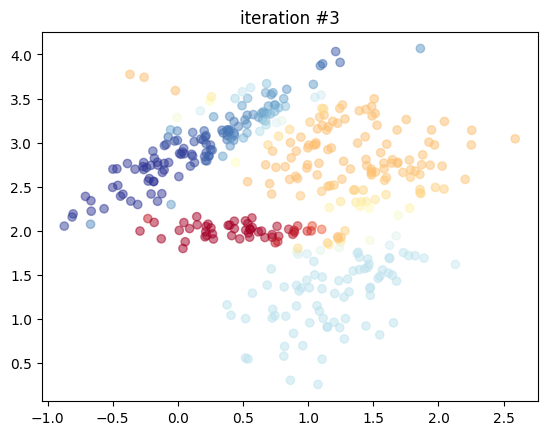

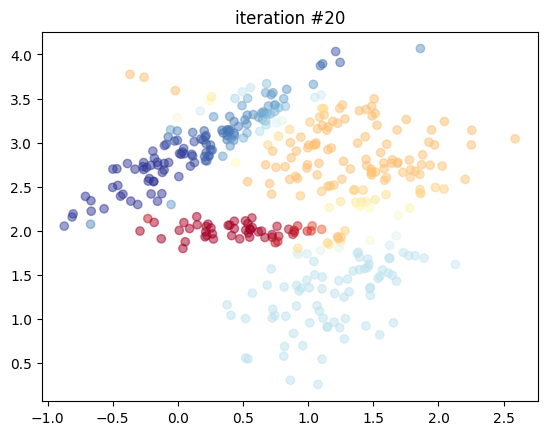

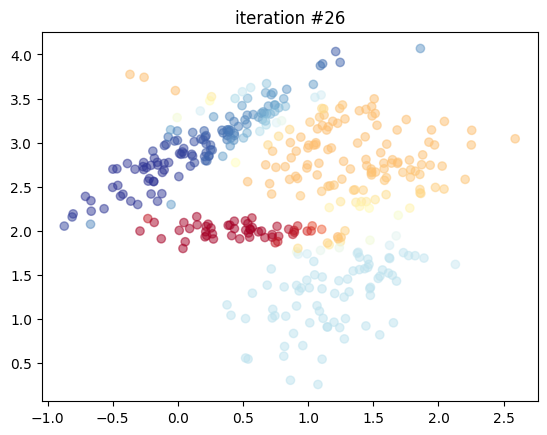

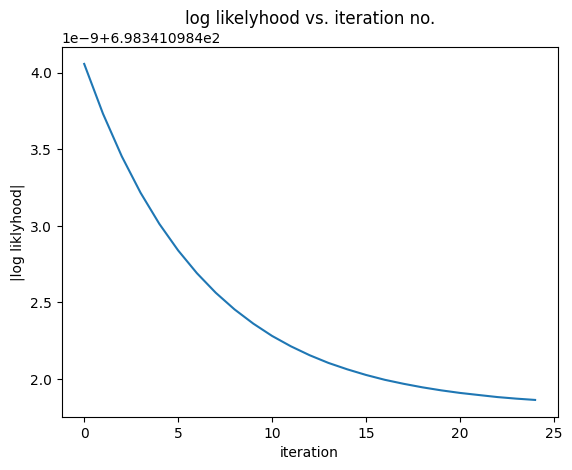

In [414]:
# run MLE
_,_,_,lol = MLE(data4,(phi4,centroids4,sigma4),case=2,tol=0.00000000001)
plot_log_likelihood(lol)

## results
the initialization proved itself to be very useful, and the algorithm converged to the right solution, after ~26 iterations. notice, in contrary to other clustering algorithms we will see in the future, it got the shaps even despite a major intersection between the 2 major clusters.

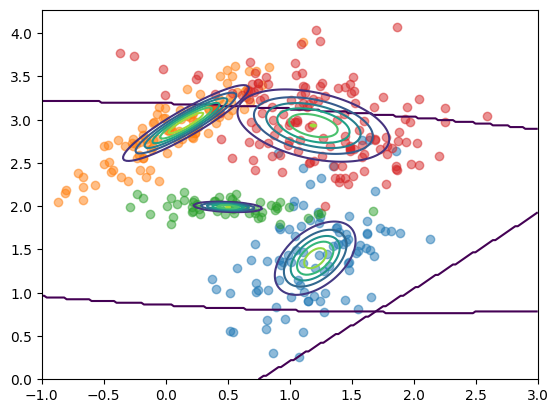

In [445]:
plot_clusters(clusters4)

for c in range (4):
    draw_contour(phi4[c],centroids4[c],sigma4[c])